<h1 style="font-size:60px;"><b>Import packages</b></h1>

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency, shapiro, ttest_ind, ks_2samp, mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from dython import nominal
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

<h1 style="font-size:60px;"><b>Download data, clean and save</b></h1>

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/mrsonuk/LDS_Test/main/Test_data.csv", index_col=0)

In [3]:
df['GenHealth'] = df['GenHealth'].replace(['Goo_d', 'goo_d', 'ExCellent'], ['Good', 'Good', 'Excellent']) 

In [4]:
df = df.rename(columns={'Dead/Alive': 'DeadorAlive'})

In [5]:
df.to_csv("Heart_disease.csv")

In [6]:
df['GenHealth'] = df['GenHealth'].replace(['Poor','Fair','Good','Very good','Excellent'], [0,1,2,3,4])
df['AgeCategory'] = df['AgeCategory'].replace([ '18-24', '25-29','30-34', '35-39', '40-44', '45-49','50-54', '55-59','60-64','65-69','70-74', '75-79','80 or older'],
                                             [0,1,2,3,4,5,6,7,8,9,10,11,12])

In [7]:
###Diabetic and Race are categorical variables with more than two levels
expand_df = pd.get_dummies(df, columns = ["Diabetic", "Race"])

In [8]:
expand_df = expand_df.rename(columns={'Diabetic_No, borderline diabetes': 'DiabeticBorderline',
                                     'Diabetic_Yes (during pregnancy)': 'DiabeticYesPregnancy',
                                     'Race_American Indian/Alaskan Native': 'RaceAmericanIndianAlaskanNative',
                                     'Race_Asian': 'RaceAsian',
                                     'Race_Black': 'RaceBlack',
                                     'Race_Hispanic': 'RaceHispanic',
                                     'Race_Other': 'RaceOther',
                                     'Race_White': 'RaceWhite'})

<h1 style="font-size:60px;"><b>Input</b></h1>

In [9]:
###this is the feature to be used as y_of_model
###"Stroke" "HeartDisease" "DeadorAlive"
###if y_of_model is "DeadorAlive" declare a subsetting variable
y_of_model = "DeadorAlive"
subset_variable = "HeartDisease"##"HeartDisease" "Stroke" or ""
if y_of_model == "DeadorAlive":
    df= df.loc[df[subset_variable] == "Yes"]
    expand_df = expand_df.loc[expand_df[subset_variable] == "Yes"]
else:
    print("nothing to subset")


<h1 style="font-size:60px;"><b>Statistical Analysis</b></h1>

In [10]:
###category_vs_category
##'HeartDisease' removed from the other categorical_features
categorical_features=  [  'HeartDisease','Smoking', 'Diabetic', 'AlcoholDrinking','Stroke', 'DiffWalking', 'Sex', 'Race', 'PhysicalActivity','Asthma', 'KidneyDisease', 'SkinCancer', 'DeadorAlive']
categorical_features.remove(y_of_model)
for feature in categorical_features:
    chisqt = pd.crosstab( eval("df."+y_of_model), eval("df."+feature),  margins=True)
    value = np.array([chisqt.iloc[0][0:(chisqt.shape[1]-1)].values,
                  chisqt.iloc[1][0:(chisqt.shape[1]-1)].values])
    print(feature+ " results:"+ str(chi2_contingency(value)[0:3]))
    

HeartDisease results:(0.0, 1.0, 0)
Smoking results:(1.0738055563351527, 0.30008744014624816, 1)
Diabetic results:(0.87692889268001, 0.8309915239153841, 3)
AlcoholDrinking results:(0.00013192396930282148, 0.9908358462370145, 1)
Stroke results:(0.61201275690144, 0.4340309765595616, 1)
DiffWalking results:(0.06986723137713112, 0.7915301891029922, 1)
Sex results:(0.05764305250927543, 0.8102607375576469, 1)
Race results:(2.359686106009373, 0.7974621288910605, 5)
PhysicalActivity results:(0.3245892340095291, 0.5688626484555688, 1)
Asthma results:(3.4571615913680334, 0.062978337580537, 1)
KidneyDisease results:(2.4815246326003804, 0.11519054282803234, 1)
SkinCancer results:(0.1055294200076107, 0.7452923898943873, 1)


In [11]:
####category_vs_continuous(and count data)
continous_and_count_data = ["BMI", "SleepTime", "PhysicalHealth", "MentalHealth"]
for continuous_or_count in continous_and_count_data:
    NO_y_of_model = df.loc[df[y_of_model] == "No", continuous_or_count]
    YES_y_of_model = df.loc[df[y_of_model] == "Yes", continuous_or_count]
    if (shapiro(np.array(eval("df."+continuous_or_count)))[1]<= 0.05) == True:   #normality check
        print("non-parametric results for "+ continuous_or_count +" "+ str(ks_2samp(NO_y_of_model, YES_y_of_model)[1]))
    else:
        print("parametric results for "+ continuous_or_count +" "+ str(ttest_ind(NO_y_of_model, YES_y_of_model, equal_var = False)[1]))
        

C:\Users\oaona\Anaconda3\envs\tf1130\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


non-parametric results for BMI 0.5545964446021714
non-parametric results for SleepTime 0.5537682558978357
non-parametric results for PhysicalHealth 0.9999999983286841
non-parametric results for MentalHealth 0.9702609022417871


In [12]:
####categorical_vs_ordinal
ordinal_data = [ "AgeCategory", "GenHealth"]
for ordinal_feature in ordinal_data:
    NO_y_of_model = df.loc[df[y_of_model] == "No", ordinal_feature]
    YES_y_of_model = df.loc[df[y_of_model] == "Yes", ordinal_feature]
    res = mannwhitneyu(x=NO_y_of_model, y=YES_y_of_model, alternative = "two-sided")[1]
    print(ordinal_feature + " result: "+ str(res))
    

AgeCategory result: 0.7072836179072859
GenHealth result: 0.6434553623621234


<h1 style="font-size:60px;"><b>Preprocessing for machine learning</b></h1>

In [13]:
if y_of_model == 'DeadorAlive':
    expand_df = expand_df.drop(columns = ["date", "Patient_ID"])
else:
    expand_df = expand_df.drop(columns = ["date", "Patient_ID",'DeadorAlive'])

In [14]:
categorical_features=  ['HeartDisease','Smoking', 'AlcoholDrinking','Stroke', 'DiffWalking', 'PhysicalActivity','Asthma', 'KidneyDisease', 'SkinCancer']
try:
    categorical_features.remove(y_of_model)
except:
    pass
try:
    categorical_features.remove(subset_variable)
except:
    pass
for feature in categorical_features:
    expand_df[feature] = expand_df[feature].replace(["No", "Yes"], [0,1])

expand_df['Sex'] = expand_df['Sex'].replace(["Male", "Female"], [0,1])   

In [15]:
####downsampling:
expand_df_yes = expand_df[expand_df[y_of_model] == "Yes"]
expand_df_no  = expand_df[expand_df[y_of_model] == "No"]
expand_df_no_downsample = resample(expand_df_no,
             replace=True,
             n_samples=len(expand_df_yes),
             random_state=42)
expand_df_downsampled = pd.concat([expand_df_no_downsample, expand_df_yes])
try:
    expand_df_downsampled = expand_df_downsampled.drop(subset_variable, axis = 1)
except:
    pass

In [16]:
####standardscaling of continuous and count variables
scaler = StandardScaler()
for candcount in continous_and_count_data:
    scaler = StandardScaler()
    scaler.fit(expand_df_downsampled[[candcount]])
    expand_df_downsampled[[candcount]] = scaler.transform(expand_df_downsampled[[candcount]])   

In [17]:
expand_df = expand_df_downsampled

In [18]:
expand_df[y_of_model] = expand_df[y_of_model].replace(['No','Yes'], [0,1])
y = expand_df[[y_of_model]]
X = expand_df.drop(y_of_model, axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.09, random_state=0, shuffle= True)

<h1 style="font-size:60px;"><b>Random Forest</b></h1>

In [19]:
### print model and matthews_corrcoef scores (-1, 0, +1)
res_list= []
print("max_features-max_depth-n_estimators-MCC-accuracy")
for x in [10, 15, 20]:
    for j in [20,25, 30, 35]:
        for w in [20, 40, 80, 100]:
            clf=RandomForestClassifier(n_estimators= w, criterion="entropy", max_depth= j, max_features= x, n_jobs =4)
            clf=clf.fit(X_train,eval("y_train."+ y_of_model +".ravel()"))
            y_pred=clf.predict(X_test)
            res= str(x)+"-"+str(j)+"-"+str(w)+"-" +str(matthews_corrcoef(y_test, y_pred)) + "-" +str(accuracy_score(y_test, y_pred)) 
            print(res)
            res_list.append(res)

max_features-max_depth-n_estimators-MCC-accuracy
10-20-20-0.3546640187538952-0.6754068716094033
10-20-40-0.39082864984132-0.6943942133815552
10-20-80-0.3944519837339628-0.6962025316455697
10-20-100-0.41165922406854605-0.705244122965642
10-25-20-0.40207891507048804-0.7007233273056058
10-25-40-0.3930009289016294-0.6952983725135624
10-25-80-0.43546040140495595-0.7179023508137432
10-25-100-0.40855409280199406-0.7043399638336347
10-30-20-0.3850880537960273-0.6907775768535263
10-30-40-0.44410834977309954-0.7224231464737794
10-30-80-0.4333973959689773-0.716998191681736
10-30-100-0.4307709101497354-0.7160940325497287
10-35-20-0.38745267621339397-0.6889692585895117
10-35-40-0.45792721800543906-0.72875226039783
10-35-80-0.4606548149297363-0.7305605786618445
10-35-100-0.455473078699265-0.7278481012658228
15-20-20-0.35944597686567314-0.6781193490054249
15-20-40-0.35077161969693416-0.6735985533453888
15-20-80-0.4155085155685984-0.7061482820976492
15-20-100-0.39469125983588177-0.6962025316455697
15-

In [52]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

BMI                                0.268611
AgeCategory                        0.190205
GenHealth                          0.095628
SleepTime                          0.082791
PhysicalHealth                     0.058508
MentalHealth                       0.055471
Smoking                            0.025996
Stroke                             0.024291
Sex                                0.024057
PhysicalActivity                   0.022691
DiffWalking                        0.021842
Asthma                             0.017745
SkinCancer                         0.017683
Diabetic_Yes                       0.015021
RaceWhite                          0.013064
KidneyDisease                      0.011880
AlcoholDrinking                    0.010536
Diabetic_No                        0.009857
RaceBlack                          0.009429
RaceHispanic                       0.007923
RaceOther                          0.005696
DiabeticBorderline                 0.004415
RaceAmericanIndianAlaskanNative 

No handles with labels found to put in legend.


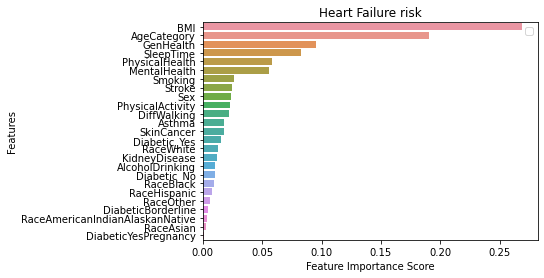

In [53]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Heart Failure risk")
plt.legend()
plt.show()

<h1 style="font-size:60px;"><b>Deep Neural Network</b></h1>

In [22]:
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(len(eval("y_train."+ y_of_model + ".unique()"))-1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=13,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [23]:
history= model.fit(X, eval("y."+ y_of_model + ".ravel()"), 
                   epochs=40, callbacks=[es], validation_split=0.09, batch_size=10).history

Epoch 1/40
2243/2243 [==============================] - 7s 3ms/step - loss: 0.5851 - accuracy: 0.7327 - val_loss: 0.3052 - val_accuracy: 0.9090
Epoch 2/40
2243/2243 [==============================] - 6s 3ms/step - loss: 0.5161 - accuracy: 0.7560 - val_loss: 0.6171 - val_accuracy: 0.6697
Epoch 3/40
2243/2243 [==============================] - 6s 3ms/step - loss: 0.5021 - accuracy: 0.7588 - val_loss: 0.5137 - val_accuracy: 0.7512
Epoch 4/40
2243/2243 [==============================] - 6s 3ms/step - loss: 0.4974 - accuracy: 0.7607 - val_loss: 0.4551 - val_accuracy: 0.7936
Epoch 5/40
2243/2243 [==============================] - 6s 3ms/step - loss: 0.4955 - accuracy: 0.7584 - val_loss: 0.6090 - val_accuracy: 0.6949
Epoch 6/40
2243/2243 [==============================] - 6s 3ms/step - loss: 0.4942 - accuracy: 0.7605 - val_loss: 0.5451 - val_accuracy: 0.7445
Epoch 7/40
2243/2243 [==============================] - 6s 3ms/step - loss: 0.4933 - accuracy: 0.7595 - val_loss: 0.5579 - val_accuracy:

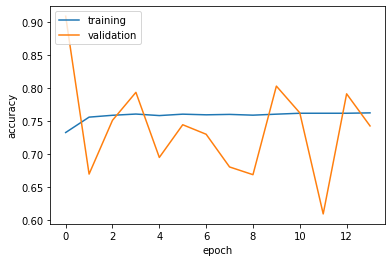

In [24]:
plt.plot(history['accuracy'], label="training")
plt.plot(history['val_accuracy'], label= "validation")
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.legend(loc="upper left")

<h1 style="font-size:60px;"><b>Logistic Regression</b></h1>

In [54]:
X_train_log, X_test_log = train_test_split(expand_df_downsampled, test_size=0.09, random_state=0, shuffle= True)

In [55]:
independent_variables = list(X_train_log.columns)
independent_variables.remove(y_of_model)
formular = y_of_model + " ~ "
for feature in independent_variables:
    formular = formular + " + " + feature
formular = formular.replace('+', '', 1)

In [56]:
model = smf.logit(formular, 
                  data = X_train_log)
model = model.fit_regularized(start_params = None, method= "l1", alpha = 0)
print(model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4907085150938149
            Iterations: 129
            Function evaluations: 130
            Gradient evaluations: 129
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                22427
Model:                          Logit   Df Residuals:                    22401
Method:                           MLE   Df Model:                           25
Date:                Mon, 28 Nov 2022   Pseudo R-squ.:                  0.2921
Time:                        11:56:41   Log-Likelihood:                -11005.
converged:                       True   LL-Null:                       -15545.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [57]:
print(model.params)

Intercept                         -1.020257
BMI                                0.073577
Smoking                            0.410877
AlcoholDrinking                   -0.189911
Stroke                             1.383941
PhysicalHealth                     0.053933
MentalHealth                       0.072000
DiffWalking                        0.180257
Sex                               -0.729651
AgeCategory                        0.291218
PhysicalActivity                   0.050118
GenHealth                         -0.504076
SleepTime                         -0.009736
Asthma                             0.312061
KidneyDisease                      0.571848
SkinCancer                         0.133111
Diabetic_No                       -0.392479
DiabeticBorderline                -0.285641
Diabetic_Yes                       0.248573
DiabeticYesPregnancy              -0.364862
RaceAmericanIndianAlaskanNative    0.053257
RaceAsian                         -0.393121
RaceBlack                       

In [58]:
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['z-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())

print(model_odds)

                                       OR        z-value      2.5%     97.5%
Intercept                        0.360502   9.999987e-01  0.000000       inf
BMI                              1.076352   4.993286e-05  1.038754  1.115310
Smoking                          1.508141   1.632882e-33  1.410756  1.612248
AlcoholDrinking                  0.827033   1.080802e-02  0.714662  0.957072
Stroke                           3.990596   2.170021e-75  3.442869  4.625461
PhysicalHealth                   1.055414   1.418862e-02  1.010889  1.101900
MentalHealth                     1.074655   1.553840e-04  1.035299  1.115508
DiffWalking                      1.197525   1.168594e-04  1.092593  1.312534
Sex                              0.482077   6.402967e-98  0.450342  0.516048
AgeCategory                      1.338057   0.000000e+00  1.320458  1.355890
PhysicalActivity                 1.051395   2.068076e-01  0.972686  1.136474
GenHealth                        0.604064  4.661782e-141  0.580916  0.628134

C:\Users\oaona\Anaconda3\envs\tf1130\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
pred = model.predict(exog=X_test_log[independent_variables])
accuracy_score(y_true=list(X_test_log[y_of_model]), y_pred=list(round(pred)))

0.761604326273096

<h1 style="font-size:60px;"><b>KNN</b></h1>

In [60]:
res_list= []
for k in range(2, 50):
    clf = KNeighborsClassifier(n_neighbors = k, p=1)
    clf=clf.fit(X_train,eval("y_train."+ y_of_model + ".ravel()"))
    y_pred=clf.predict(X_test)
    res= str(k)+"-" +str(matthews_corrcoef(y_test, y_pred))
    print(res)
    res_list.append(res)

2-0.37522557857930616
3-0.43382386743581824
4-0.4190911751379819
5-0.45745086881131425
6-0.4496589852752266
7-0.4717134922810021
8-0.47143882817336047
9-0.4887014063644228
10-0.48339904988471616
11-0.4941575757210551
12-0.47181605077655836
13-0.4914041172527169
14-0.4823047363953473
15-0.4887299076225724
16-0.48303755837488543
17-0.49234027060920776
18-0.49368597950150817
19-0.49592349082661863
20-0.4882386219482748
21-0.4968227075719741
22-0.49789228382421324
23-0.49688720496924166
24-0.49332950966939654
25-0.4941713161504035
26-0.5040821481528633
27-0.5058855267435004
28-0.5014155812102259
29-0.5049765410624315
30-0.5112730015277837
31-0.5087411904056934
32-0.5076376100129459
33-0.5105225322745206
34-0.5121496988954841
35-0.5141886629563706
36-0.5094723147284493
37-0.5060715189916508
38-0.5040412939942052
39-0.5078509898086633
40-0.5094420819845016
41-0.505103124585958
42-0.5112463277361221
43-0.503296655356437
44-0.5103542911994176
45-0.5097460462155712
46-0.5166738202331095
47-0.52